The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l
!pip install -U mxnet-cu101==1.7.0


# 多GPU的简洁实现
:label:`sec_multi_gpu_concise`

每个新模型的并行计算都从零开始实现是无趣的。此外，优化同步工具以获得高性能也是有好处的。下面我们将展示如何使用深度学习框架的高级API来实现这一点。数学和算法与 :numref:`sec_multi_gpu`中的相同。本节的代码至少需要两个GPU来运行。


In [1]:
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

## [**简单网络**]

让我们使用一个比 :numref:`sec_multi_gpu`的LeNet更有意义的网络，它依然能够容易地和快速地训练。我们选择的是 :cite:`He.Zhang.Ren.ea.2016`中的ResNet-18。因为输入的图像很小，所以稍微修改了一下。与 :numref:`sec_resnet`的区别在于，我们在开始时使用了更小的卷积核、步长和填充，而且删除了最大汇聚层。


In [2]:
#@save
def resnet18(num_classes):
    """稍加修改的ResNet-18模型"""
    def resnet_block(num_channels, num_residuals, first_block=False):
        blk = nn.Sequential()
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.add(d2l.Residual(
                    num_channels, use_1x1conv=True, strides=2))
            else:
                blk.add(d2l.Residual(num_channels))
        return blk

    net = nn.Sequential()
    # 该模型使用了更小的卷积核、步长和填充，而且删除了最大汇聚层
    net.add(nn.Conv2D(64, kernel_size=3, strides=1, padding=1),
            nn.BatchNorm(), nn.Activation('relu'))
    net.add(resnet_block(64, 2, first_block=True),
            resnet_block(128, 2),
            resnet_block(256, 2),
            resnet_block(512, 2))
    net.add(nn.GlobalAvgPool2D(), nn.Dense(num_classes))
    return net

## 网络初始化


`initialize`函数允许我们在所选设备上初始化参数。请参阅 :numref:`sec_numerical_stability`复习初始化方法。这个函数在多个设备上初始化网络时特别方便。下面在实践中试一试它的运作方式。


In [3]:
net = resnet18(10)
# 获取GPU列表
devices = d2l.try_all_gpus()
# 初始化网络的所有参数
net.initialize(init=init.Normal(sigma=0.01), ctx=devices)

使用 :numref:`sec_multi_gpu`中引入的`split_and_load`函数可以切分一个小批量数据，并将切分后的分块数据复制到`devices`变量提供的设备列表中。网络实例自动使用适当的GPU来计算前向传播的值。我们将在下面生成$4$个观测值，并在GPU上将它们拆分。


In [4]:
x = np.random.uniform(size=(4, 1, 28, 28))
x_shards = gluon.utils.split_and_load(x, devices)
net(x_shards[0]), net(x_shards[1])

[15:16:26] src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


(array([[ 2.2610211e-06,  2.2045972e-06, -5.4046791e-06,  1.2869948e-06,
          5.1373177e-06, -3.8298003e-06,  1.4338821e-07,  5.4683446e-06,
         -2.8279219e-06, -3.9651136e-06],
        [ 2.0698681e-06,  2.0084683e-06, -5.6382510e-06,  1.0498468e-06,
          5.5506434e-06, -4.1065496e-06,  6.0829746e-07,  5.4521779e-06,
         -3.7365003e-06, -4.1891681e-06]], ctx=gpu(0)),
 array([[ 2.4629780e-06,  2.6015496e-06, -5.4362640e-06,  1.2938228e-06,
          5.6387917e-06, -4.1360136e-06,  3.5758910e-07,  5.5125265e-06,
         -3.1957322e-06, -4.2976326e-06],
        [ 1.9431645e-06,  2.2600461e-06, -5.2698206e-06,  1.4807421e-06,
          5.4830953e-06, -3.9678876e-06,  7.5752382e-08,  5.6764370e-06,
         -3.2530270e-06, -4.0943969e-06]], ctx=gpu(1)))

一旦数据通过网络，网络对应的参数就会在*有数据通过的设备上初始化*。这意味着初始化是基于每个设备进行的。由于我们选择的是GPU0和GPU1，所以网络只在这两个GPU上初始化，而不是在CPU上初始化。事实上，CPU上甚至没有这些参数。我们可以通过打印参数和观察可能出现的任何错误来验证这一点。


In [5]:
weight = net[0].params.get('weight')

try:
    weight.data()
except RuntimeError:
    print('not initialized on cpu')
weight.data(devices[0])[0], weight.data(devices[1])[0]

not initialized on cpu


(array([[[ 0.01382882, -0.01183044,  0.01417865],
         [-0.00319718,  0.00439528,  0.02562625],
         [-0.00835081,  0.01387452, -0.01035946]]], ctx=gpu(0)),
 array([[[ 0.01382882, -0.01183044,  0.01417865],
         [-0.00319718,  0.00439528,  0.02562625],
         [-0.00835081,  0.01387452, -0.01035946]]], ctx=gpu(1)))

接下来，让我们使用[**在多个设备上并行工作**]的代码来替换前面的[**评估模型**]的代码。
这里主要是 :numref:`sec_lenet`的`evaluate_accuracy_gpu`函数的替代，代码的主要区别在于在调用网络之前拆分了一个小批量，其他在本质上是一样的。


In [6]:
#@save
def evaluate_accuracy_gpus(net, data_iter, split_f=d2l.split_batch):
    """使用多个GPU计算数据集上模型的精度"""
    # 查询设备列表
    devices = list(net.collect_params().values())[0].list_ctx()
    # 正确预测的数量，预测的总数量
    metric = d2l.Accumulator(2)
    for features, labels in data_iter:
        X_shards, y_shards = split_f(features, labels, devices)
        # 并行运行
        pred_shards = [net(X_shard) for X_shard in X_shards]
        metric.add(sum(float(d2l.accuracy(pred_shard, y_shard)) for
                       pred_shard, y_shard in zip(
                           pred_shards, y_shards)), labels.size)
    return metric[0] / metric[1]

## [**训练**]

如前所述，用于训练的代码需要执行几个基本功能才能实现高效并行：

* 需要在所有设备上初始化网络参数；
* 在数据集上迭代时，要将小批量数据分配到所有设备上；
* 跨设备并行计算损失及其梯度；
* 聚合梯度，并相应地更新参数。

最后，并行地计算精确度和发布网络的最终性能。除了需要拆分和聚合数据外，训练代码与前几章的实现非常相似。


In [7]:
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    ctx = [d2l.try_gpu(i) for i in range(num_gpus)]
    net.initialize(init=init.Normal(sigma=0.01), ctx=ctx, force_reinit=True)
    trainer = gluon.Trainer(net.collect_params(), 'sgd',
                            {'learning_rate': lr})
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    timer, num_epochs = d2l.Timer(), 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    for epoch in range(num_epochs):
        timer.start()
        for features, labels in train_iter:
            X_shards, y_shards = d2l.split_batch(features, labels, ctx)
            with autograd.record():
                ls = [loss(net(X_shard), y_shard) for X_shard, y_shard
                      in zip(X_shards, y_shards)]
            for l in ls:
                l.backward()
            trainer.step(batch_size)
        npx.waitall()
        timer.stop()
        animator.add(epoch + 1, (evaluate_accuracy_gpus(net, test_iter),))
    print(f'测试精度：{animator.Y[0][-1]:.2f}，{timer.avg():.1f}秒/轮，'
          f'在{str(ctx)}')

接下来看看这在实践中是如何运作的。我们先[**在单个GPU上训练网络**]进行预热。


测试精度：0.92，13.4秒/轮，在[gpu(0)]


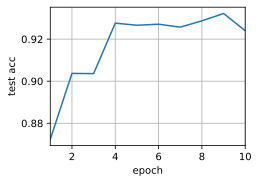

In [8]:
train(num_gpus=1, batch_size=256, lr=0.1)

接下来我们[**使用2个GPU进行训练**]。与 :numref:`sec_multi_gpu`中评估的LeNet相比，ResNet-18的模型要复杂得多。这就是显示并行化优势的地方，计算所需时间明显大于同步参数需要的时间。因为并行化开销的相关性较小，因此这种操作提高了模型的可伸缩性。


测试精度：0.91，6.9秒/轮，在[gpu(0), gpu(1)]


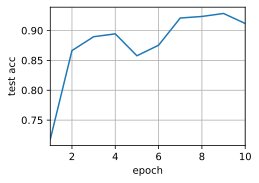

In [9]:
train(num_gpus=2, batch_size=512, lr=0.2)

## 小结


* Gluon通过提供一个上下文列表，为跨多个设备的模型初始化提供原语。
* 神经网络可以在（可找到数据的）单GPU上进行自动评估。
* 每台设备上的网络需要先初始化，然后再尝试访问该设备上的参数，否则会遇到错误。
* 优化算法在多个GPU上自动聚合。


## 练习


1. 本节使用ResNet-18，请尝试不同的迭代周期数、批量大小和学习率，以及使用更多的GPU进行计算。如果使用$16$个GPU（例如，在AWS p2.16xlarge实例上）尝试此操作，会发生什么？
1. 有时候不同的设备提供了不同的计算能力，我们可以同时使用GPU和CPU，那应该如何分配工作？为什么？
1. 如果去掉`npx.waitall()`会怎样？该如何修改训练，以使并行操作最多有两个步骤重叠？


[Discussions](https://discuss.d2l.ai/t/2804)
